In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import os

from dotenv import load_dotenv, find_dotenv

from ethos.constants import PROJECT_DATA
from ethos.datasets import ReadmissionDataset
from ethos.tokenize import Vocabulary
from ethos.utils import load_data

# load .env file with the API key and the API endpoint
_ = load_dotenv(find_dotenv())

data_dir = PROJECT_DATA / "tokenized_datasets"

vocab = Vocabulary(data_dir / "mimic_vocab_t4367.pkl")
decode = vocab.decode

data = load_data(data_dir / "mimic_test_timelines_p26758.hdf5")
block_size = 2048
dataset = ReadmissionDataset(data, vocab.encode, block_size)
context_size = dataset.context_len
f"Number of instances: {len(dataset):,}"

'Number of instances: 42,440'

In [3]:
timeline, y = dataset[5]
decode(timeline[:]), y
ctx = decode(timeline[:context_size])
patient_history = decode(timeline[context_size:])
ctx, len(patient_history)

(array(['SEX_M', 'RACE_ASIAN', 'MARITAL_MARRIED', '_Q1', '_60-65y',
        '_40-45y'], dtype=object),
 2042)

In [4]:
def ctx_to_values(context: list):
    return {
        "gender": "male" if context[0][-1].lower() == "m" else "female",
        "race": context[1].lower()[5:],
        "marital_status": context[2].lower()[len("MARITAL_"):],
        "bmi_q": context[3][2:],
        **{
            f"age_{i}": age
            for i, age in enumerate(context[4][1:-1].split("-"))
        },
        **{
            f"year_{i}": int(year) + 1970 for i, year in enumerate(context[5][1:-1].split("-"))
        },
    }

In [5]:
from string import Template

PROMPT = Template("""Your task is to determine the probability of a patient being readmitted to the hospital within 30 days \
following their discharge. Using the provided patient context and a timeline of health events from their \
Electronic Health Records (EHR), perform the following steps:

1. Review the basic information about the patient to understand their general health profile.
2. Analyze the health events from the EHR data, which are detailed in a specialized language as described \
below. Consider these events in chronological order to gauge recent and relevant health activities.
3. Based on your analysis, provide a probability of the patient being readmitted within the next 30 days \
as a 3-decimal floating point value. Please provided solely the probability without \
any additional explanatory text. Your precise and context-aware analysis is crucial for an accurate prediction.

Patient Context:
```
The patient is a ${marital_status}, ${race} ${gender}, aged between ${age_0} and ${age_1} years. Their Body \
Mass Index (BMI) ranks in the ${bmi_q}th decile of the population. The health history timeline begins between \
the years ${year_0} and ${year_1}.
```

Timeline Event Language Guide:
- Lab Results (`LAB_` prefix): Represents laboratory test results. Each lab test's name is prefixed with `LAB_`, \
followed by the specific test name and its measurement units incorporated within. The result is given in a decile \
form (from `Q1` for the lowest decile to `Q10` for the highest decile), representing the patient’s result as \
compared to the general population.
- Diagnoses (`ICD_` prefix): Relates to diagnosis codes from the ICD-10 classification. Each code starts with \
`ICD_` and may be split across up to three consecutive events. The initial segment provides a plain language description \
of the condition or diagnosis. Subsequent segments delve deeper into the specific aspects of the code, enhancing the \
granularity of the diagnosis provided.
- Medications (`ATC_` prefix): Concerns medication prescriptions or administrations, coded according to the Anatomical \
Therapeutic Chemical (ATC) Classification System. Each medication event starts with `ATC_`, followed by a breakdown of up \
to three parts of the hierarchical ATC code, each part further refining the type of medication involved. The first part \
conveys the general therapeutic class. The second part of the code starts with `ATC_4` prefix and provides a more specific \
pharmacological subgroup. The third part, if present, specifies the suffix of the ATC code.
- Time Intervals: Marks the passage of time with specific tokens (e.g., `5m-15m`, `15m-1h`, `1h-2h`, etc.). These \
intervals help contextualize the timing between health events, indicating how much time has elapsed between documented \
events. All events without a time interval token are assumed to occur simultaneously.
- Hospital Admissions (`{X}_ADMISSION_START` and `{X}_ADMISSION_END`): These tokens signify the beginning and end of a hospital \
or specific department stay. `{X}` can be replaced with `ED` for Emergency Department, `INPATIENT` for an inpatient unit, \
or `ICU` for Intensive Care Unit. Each admission event is followed by a decile ranking of the length of stay compared to other \
similar stays, and in the case of inpatient stays, also includes the associated Diagnosis-Related Group (DRG) code.
- Transfers (`TRANSFER_` prefix): Indicates when a patient is transferred between different departments within a hospital. \
The specific departments involved are appended to the prefix, giving a clear indication of the patient's movement within the \
healthcare facility.
- Additional Events: Any other events not specifically categorized by the above prefixes are described in a straightforward \
manner based on their names, assuming that their implications are clear from the context or common medical knowledge.

Patient history in the form of a timeline of health events:
```
${patient_history}
```
""")


def create_prompt(_timeline):
    _timeline = decode(_timeline)
    context, _timeline = _timeline[:context_size], _timeline[context_size:]
    _timeline = (str(t).strip().replace(" ", "_") for t in _timeline)
    _timeline = [t[1:] if t.startswith("_") else t for t in _timeline]
    return PROMPT.substitute(ctx_to_values(context), patient_history=" ".join(_timeline))


example_prompt = create_prompt(timeline)
tokenization_factor = 3  # average token length in the prompt for gpt3.5
input_token_price = 0.005  # price for 1k tokens in dollars
input_tokens = len(example_prompt) / tokenization_factor
input_price = input_tokens * input_token_price / 1000
example_prompt, input_tokens, input_price

("Your task is to determine the probability of a patient being readmitted to the hospital within 30 days following their discharge. Using the provided patient context and a timeline of health events from their Electronic Health Records (EHR), perform the following steps:\n\n1. Review the basic information about the patient to understand their general health profile.\n2. Analyze the health events from the EHR data, which are detailed in a specialized language as described below. Consider these events in chronological order to gauge recent and relevant health activities.\n3. Based on your analysis, provide a probability of the patient being readmitted within the next 30 days as a 3-decimal floating point value in the range of 0 to 1. Please provided solely the probability without any additional explanatory text. Your precise and context-aware analysis is crucial for an accurate prediction.\n\nPatient Context:\n```\nThe patient is a married, asian male, aged between 60 and 65 years. Their

In [6]:
import openai

client = openai.AzureOpenAI(
    azure_endpoint=os.getenv("OPENAI_AZURE_ENDPOINT"),
    api_version="2024-02-15-preview"
)
llm_model = 'pawel_gpt_4o'  # :)


def generate_chatgpt_reply(llm_model, prompt, temp=0.3) -> openai.ChatCompletion:
    messages = [
        {"role": "system",
         "content": "You are a prediction model that analyzes patient health timelines."},
        {"role": "user", "content": prompt}
    ]
    return client.chat.completions.create(
        model=llm_model,
        messages=messages,
        temperature=temp,
        max_tokens=5
    )

In [82]:
from ethos.constants import PROJECT_ROOT
from tqdm import tqdm
from time import time, sleep
from collections import deque

temp = 0.5
output_dir = PROJECT_ROOT / "results" / f"readmission_llm_temp{temp:.1f}"
output_dir.mkdir(exist_ok=True)
jobs_done = set(json.load(fp.open("r"))["gt"]["discharge_token_idx"] for fp in output_dir.iterdir())

input_token_price = 0.005  # price for 1k tokens in dollars


def get_money_spent(res_dir) -> str:
    jsons = (json.load(fp.open("r")) for fp in res_dir.iterdir())
    prompt_tokens, completion_tokens = [], []
    for res in jsons:
        prompt_tokens.append(res["usage"]["prompt_tokens"])
        completion_tokens.append(res["usage"]["completion_tokens"])
    prompt_tokens_price = sum(prompt_tokens) * input_token_price / 1_000
    completion_tokens_price = sum(completion_tokens) * input_token_price * 3 / 1_000
    return f"${prompt_tokens_price + completion_tokens_price:.2f}"


max_tokens_per_min = 150_000
total_tokens = locals().get("total_tokens", deque())

n = 2_000
p_bar = tqdm((dataset[i] for i in range(n)), total=n, smoothing=0)
for timeline, y in p_bar:
    if y["discharge_token_idx"] in jobs_done:
        p_bar.set_description(f"Skipping job {y['discharge_token_idx']}")
        continue
    prompt = create_prompt(timeline)
    estimated_tokens = len(prompt) / tokenization_factor

    while total_tokens and total_tokens[0][0] < time() - 60:
        total_tokens.popleft()
    while sum(t[1] for t in total_tokens) + estimated_tokens > max_tokens_per_min:
        while total_tokens and total_tokens[0][0] < time() - 60:
            total_tokens.popleft()
        wait_time = max(60 - (time() - total_tokens[0][0]), 0)
        p_bar.set_description(f"Waiting {wait_time:.0f}s")
        p_bar.set_postfix(money_spent=get_money_spent(output_dir))
        sleep(wait_time)

    p_bar.set_description(f"Processing job {y['discharge_token_idx']}")
    response = generate_chatgpt_reply(llm_model, prompt, temp=temp)
    response = response.to_dict()
    response["gt"] = y
    json.dump(response, (output_dir / f"{response['id']}.json").open("w"))

    total_tokens.append((response["created"], response["usage"]["total_tokens"]))

Processing job 1469552: 100%|██████████| 2000/2000 [52:24<00:00,  1.57s/it, money_spent=$59.78]


In [86]:
import pandas as pd


def parse_llm_answers(res_dir) -> pd.Series:
    jsons = (json.load(fp.open("r")) for fp in res_dir.iterdir())
    res = [
        (res["choices"][0]["message"]["content"], res["gt"]["discharge_token_idx"])
        for res in jsons
    ]

    res = pd.DataFrame(res, columns=["actual", "discharge_token_idx"])
    res.set_index("discharge_token_idx", inplace=True)
    res = res["actual"].astype(float)
    assert res.index.is_unique, "Duplicate discharge_token_idx"
    nan_values = res.isna()
    if nan_values.any():
        print(f"Number of NaN values: {nan_values.sum()}")
        return res[~nan_values]
    return res

In [119]:
from ethos.constants import ADMISSION_STOKEN
from ethos.metrics import compute_basic_metrics, compute_gaussian_metrics, print_auc_roc_plot, \
    process_readmission_results

readmission_period = 30 / 365.25
model_name = "mimic_layer_6_batch_32_do_0.3_best_test"

ethos_results = (
    process_readmission_results(f"readmission_{model_name}", ADMISSION_STOKEN, readmission_period)
    [["expected", "discharge_token_idx", "actual"]]
    .set_index("discharge_token_idx")
)

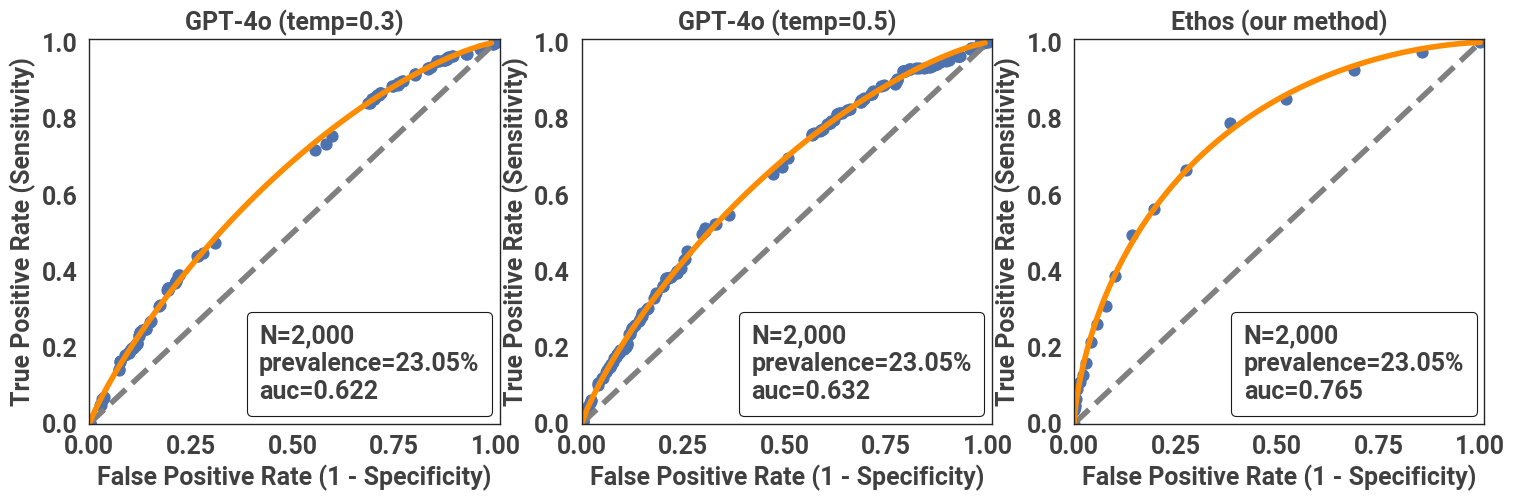

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

black_color = "#404040ff"
gray_color = "#b2b2b2ff"
orange_color = "#ff8533ff"
font_size = 18

sns.set(context="paper", style="white")

plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['font.size'] = font_size
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelcolor'] = black_color
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlecolor'] = black_color
plt.rcParams['axes.titlesize'] = font_size
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['text.color'] = black_color
plt.rcParams['xtick.color'] = black_color
plt.rcParams['xtick.labelsize'] = font_size
plt.rcParams['ytick.color'] = black_color
plt.rcParams['ytick.labelsize'] = font_size
plt.rcParams['lines.markersize'] = 8

# the results included in the paper can be downloaded from Google Drive, refer to README
res_dir = PROJECT_ROOT / "results"
results = ethos_results.copy()

for temp in [0.3, 0.5]:
    answers = parse_llm_answers(res_dir / f"readmission_llm_temp{temp:.1f}")
    answers.name = f"gpt4o_temp{temp:.1f}"
    results = results.join(answers, how="inner")

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
basic_res = compute_basic_metrics(results["expected"], results["gpt4o_temp0.3"])
gaussian_res = compute_gaussian_metrics(results["expected"], results["gpt4o_temp0.3"])
print_auc_roc_plot(basic_res, gaussian_res, f"GPT-4o (temp=0.3)", clinical=True, lw=4)

plt.subplot(1, 3, 2)
basic_res = compute_basic_metrics(results["expected"], results["gpt4o_temp0.5"])
gaussian_res = compute_gaussian_metrics(results["expected"], results["gpt4o_temp0.5"])
print_auc_roc_plot(basic_res, gaussian_res, f"GPT-4o (temp=0.5)", clinical=True, lw=4)

plt.subplot(1, 3, 3)
basic_res = compute_basic_metrics(results["expected"], results["actual"])
gaussian_res = compute_gaussian_metrics(results["expected"], results["actual"])
print_auc_roc_plot(basic_res, gaussian_res, f"Ethos (our method)", clinical=True, lw=4)